In [1]:
import numpy as np
import scipy
from scipy import integrate, interpolate
from scipy.misc import derivative
from scipy.special import comb
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import utilities_simple as utilities

In [2]:
c = 299792.458           #km/s
GN = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc = 3.086e19     # km

In [4]:
cosmo_params = {
...     'OmegaM' : 0.2999,
...     'OmegaDE': 0.7,
...     'OmegaR' : 1.e-4,
...     'h'     : 0.7,
... }

In [5]:
ligo_asd = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')


In [6]:
ligo_interp = interpolate.interp1d(ligo_asd[:,0],ligo_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

In [7]:
m1 = 36       #solarmass
m2 = 29

Dl = 410      #Mpc
zem = 0.09

time = 2*365*24*3600    # time before merger in sec

tc = 0
psic = 0

In [8]:
m_eff = m1*m2/(m1+m2)
Ms = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta = ((m1+m2)/Ms)**(-5./3)

Dl_s = Dl*Mpc/c        # Dl in sec

Ms_s = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger

f_cut = utilities.get_freq(Mtot_s, eta, "cut")

fc = utilities.inspiral_fc(Mtot_s)

farr = np.logspace(np.log10(f_start),np.log10(fc),num=500)  #inspiral range only

Dl_arr = np.array([Dl_s]*len(farr))

f_plot = np.logspace(np.log10(f_start),np.log10(f_cut),num=500)     # full IMR waveform

In [9]:
print(eta)
print(fc)

0.24710059171597634
67.63181124855085


In [10]:
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

h_GR = utilities.waveform(farr, pars_GR, cosmo_params)
h_plot = utilities.waveform(f_plot, pars_GR, cosmo_params)

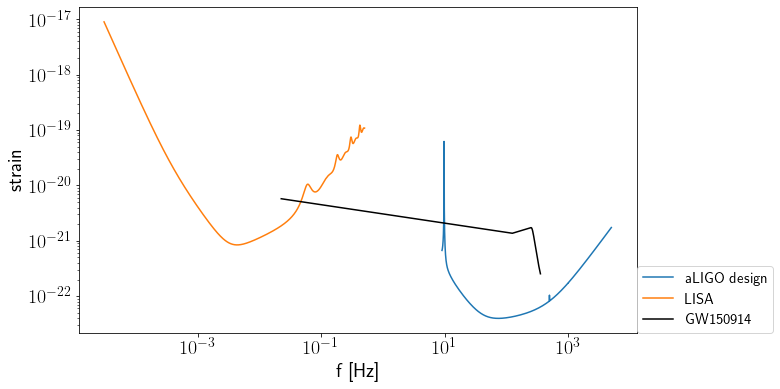

In [11]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(f_plot, np.abs(f_plot*h_plot), color='k', label='GW150914')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc=(1,0))

In [12]:
farr_ligo = np.logspace(np.log10(ligo_asd[0,0]),np.log10(fc),num=500)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=500)

ligo_psd = ligo_interp(farr_ligo)**2
lisa_psd = lisa_interp(farr_lisa)

h_GR_ligo = utilities.waveform(farr_ligo, pars_GR, cosmo_params)
h_GR_lisa = utilities.waveform(farr_lisa, pars_GR, cosmo_params)


In [13]:
SNR_ligo_sq = utilities.scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)
SNR_ligo = np.sqrt(SNR_ligo_sq)

SNR_lisa_sq = utilities.scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)
SNR_lisa = np.sqrt(SNR_lisa_sq)

print('design LIGO SNR')
print(SNR_ligo)
print('LISA SNR')
print(SNR_lisa)

design LIGO SNR
65.53220995174956
LISA SNR
3.432512161696213


# GR Constraints

In [14]:
# numerical derivatives w.r.t. lnMz
dh_dlnMz_func = lambda lnMz_func: utilities.waveform(farr_ligo, [lnMz_func, np.log(eta), np.log(zem), tc, psic], cosmo_params)
dh_dlnMz_ligo = derivative(dh_dlnMz_func, np.log(Ms), dx=np.log(Ms)*1.e-8)

# numerical derivatives w.r.t. lneta
dh_dlneta_func = lambda lneta_func: utilities.waveform(farr_ligo, [np.log(Ms), lneta_func, np.log(zem), tc, psic], cosmo_params)
dh_dlneta_ligo = derivative(dh_dlneta_func, np.log(eta), dx=np.log(eta)*1.e-4)

# numerical derivatives w.r.t. lnz
dh_dlnz_func = lambda lnz_func: utilities.waveform(farr_ligo, [np.log(Ms), np.log(eta), lnz_func, tc, psic], cosmo_params)
dh_dlnz_ligo = derivative(dh_dlnz_func, np.log(zem), dx=np.log(zem)*1.e-3)
# dh_dlnDl_func = lambda lnDl_func: utilities.waveform(farr_ligo, [np.log(eta), np.log(Ms), np.log(zem), tc, psic, lnDl_func], cosmo_params, which_wf='GR')
# dh_dlnDl_ligo = derivative(dh_dlnDl_func, np.log(Dl), dx=np.log(Dl)*1.e-3)

dh_dtc_func = lambda tc_func: utilities.waveform(farr_ligo, [np.log(Ms), np.log(eta), np.log(zem), tc_func, psic], cosmo_params)
dh_dtc_ligo = derivative(dh_dtc_func, tc, dx=1.e-3)

# numerical derivatives w.r.t. psic
dh_dpsic_func = lambda psic_func: utilities.waveform(farr_ligo, [np.log(Ms), np.log(eta), np.log(zem), tc, psic_func], cosmo_params)
dh_dpsic_ligo = derivative(dh_dpsic_func, psic, dx=1.e-3)


In [15]:
# numerical derivatives w.r.t. lnMz
dh_dlnMz_func = lambda lnMz_func: utilities.waveform(farr_lisa, [lnMz_func, np.log(eta), np.log(zem), tc, psic], cosmo_params)
dh_dlnMz_lisa = derivative(dh_dlnMz_func, np.log(Ms), dx=np.log(Ms)*1.e-8)

# numerical derivatives w.r.t. lneta
dh_dlneta_func = lambda lneta_func: utilities.waveform(farr_lisa, [np.log(Ms), lneta_func, np.log(zem), tc, psic], cosmo_params)
dh_dlneta_lisa = derivative(dh_dlneta_func, np.log(eta), dx=np.log(eta)*1.e-4)

# numerical derivatives w.r.t. lnz
dh_dlnz_func = lambda lnz_func: utilities.waveform(farr_lisa, [np.log(Ms), np.log(eta), lnz_func, tc, psic], cosmo_params)
dh_dlnz_lisa = derivative(dh_dlnz_func, np.log(zem), dx=np.log(zem)*1.e-3)
# dh_dlnDl_func = lambda lnDl_func: utilities.waveform(farr_ligo, [np.log(eta), np.log(Ms), np.log(zem), tc, psic, lnDl_func], cosmo_params, which_wf='GR')
# dh_dlnDl_ligo = derivative(dh_dlnDl_func, np.log(Dl), dx=np.log(Dl)*1.e-3)

dh_dtc_func = lambda tc_func: utilities.waveform(farr_lisa, [np.log(Ms), np.log(eta), np.log(zem), tc_func, psic], cosmo_params)
dh_dtc_lisa = derivative(dh_dtc_func, tc, dx=1.e-3)

# numerical derivatives w.r.t. psic
dh_dpsic_func = lambda psic_func: utilities.waveform(farr_lisa, [np.log(Ms), np.log(eta), np.log(zem), tc, psic_func], cosmo_params)
dh_dpsic_lisa = derivative(dh_dpsic_func, psic, dx=1.e-3)


In [16]:
def Fisher_det(farr, pars, psd, cosmo_params, which_wf='GR', MG_flag=False, width=0):
    
    if which_wf=='GR':
        waveform = utilities.waveform
    elif which_wf=='EFT':
        waveform = utilities.waveform_delta(cosmo=cosmo_params, cT_type='EFT').h_Delta_exact
    elif which_wf=='step':
        waveform = utilities.waveform_delta(cosmo=cosmo_params, cT_type='step', width=width).h_Delta_exact
    
    hf = waveform(farr, pars, cosmo_params)

    dh_dlnMz_func = lambda lnMz_func: waveform(farr, [lnMz_func, pars[1], pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params)
    dh_dlnMz = derivative(dh_dlnMz_func, pars[1], dx=pars[1]*1.e-8)

    # numerical derivatives w.r.t. lneta
    dh_dlneta_func = lambda lneta_func: waveform(farr, [pars[0], lneta_func, pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params)
    dh_dlneta = derivative(dh_dlneta_func, pars[0], dx=pars[0]*1.e-4)

    # numerical derivatives w.r.t. lnz
    dh_dlnz_func = lambda lnz_func: waveform(farr, [pars[0], pars[1], lnz_func, pars[3], pars[4], pars[5], pars[6]], cosmo_params)
    dh_dlnz = derivative(dh_dlnz_func, pars[2], dx=np.log(zem)*1.e-6)
#     dh_dlnDl_func = lambda lnDl_func: utilities.waveform(farr_ligo, [pars[0], pars[1], pars[2], pars[3], pars[4], lnDl_func], cosmo_params, which_wf)
#     dh_dlnDl = derivative(dh_dlnDl_func, pars[5], dx=np.log(Dl)*1.e-3)

    dh_dtc_func = lambda tc_func: waveform(farr, [pars[0], pars[1], pars[2], tc_func, pars[4], pars[5], pars[6]], cosmo_params)
    dh_dtc = derivative(dh_dtc_func, pars[3], dx=1.e-3)

    # numerical derivatives w.r.t. psic
    dh_dpsic_func = lambda psic_func: waveform(farr, [pars[0], pars[1], pars[2], pars[3], psic_func, pars[5], pars[6]], cosmo_params)
    dh_dpsic = derivative(dh_dpsic_func, pars[4], dx=1.e-3)

    dh_dc0_func = lambda c0_func: waveform(farr, [pars[0], pars[1], pars[2], pars[3], pars[4], c0_func, pars[6]], cosmo_params)
    dh_dc0 = derivative(dh_dc0_func, pars[5], dx=1.e-6)

    if MG_flag==True:
        derivatives = [dh_dlnMz, dh_dlneta, dh_dlnz, dh_dtc, dh_dpsic, dh_dc0]
    else:
        derivatives = [dh_dlnMz, dh_dlneta, dh_dlnz, dh_dtc, dh_dpsic]

    nparams = len(derivatives)

    plabels = ['lnMz','lneta','lnz','tc','psic', 'c0']

    Fisher_matrix = np.zeros((nparams,nparams))

    for i in range(0,nparams):
        for j in range(0,nparams):
            Fisher_matrix[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], psd, farr)

    connum = np.linalg.cond(Fisher_matrix)
    print(connum)
    cov_matrix = np.linalg.inv(Fisher_matrix)

    pconstraints = np.sqrt(np.diag(cov_matrix))

    return pconstraints, cov_matrix

In [17]:
pconstraints_ligo, cov_matrix_ligo = Fisher_det(farr_ligo, pars_GR, ligo_psd, cosmo_params, which_wf='GR')
print('LIGO design')
print(pconstraints_ligo)

48281372.893245
LIGO design
[6.91078031e-06 3.21442117e-04 1.43875824e-02 1.75138360e-04
 4.79236727e-02]


In [18]:
pconstraints_lisa, cov_matrix_lisa = Fisher_det(farr_lisa, pars_GR, lisa_psd, cosmo_params, which_wf='GR')
print('LISA')
print(pconstraints_lisa)

72173468265252.19
LISA
[2.96235169e-07 1.39806361e-04 2.75033164e-01 2.45471774e+00
 5.97115736e-01]


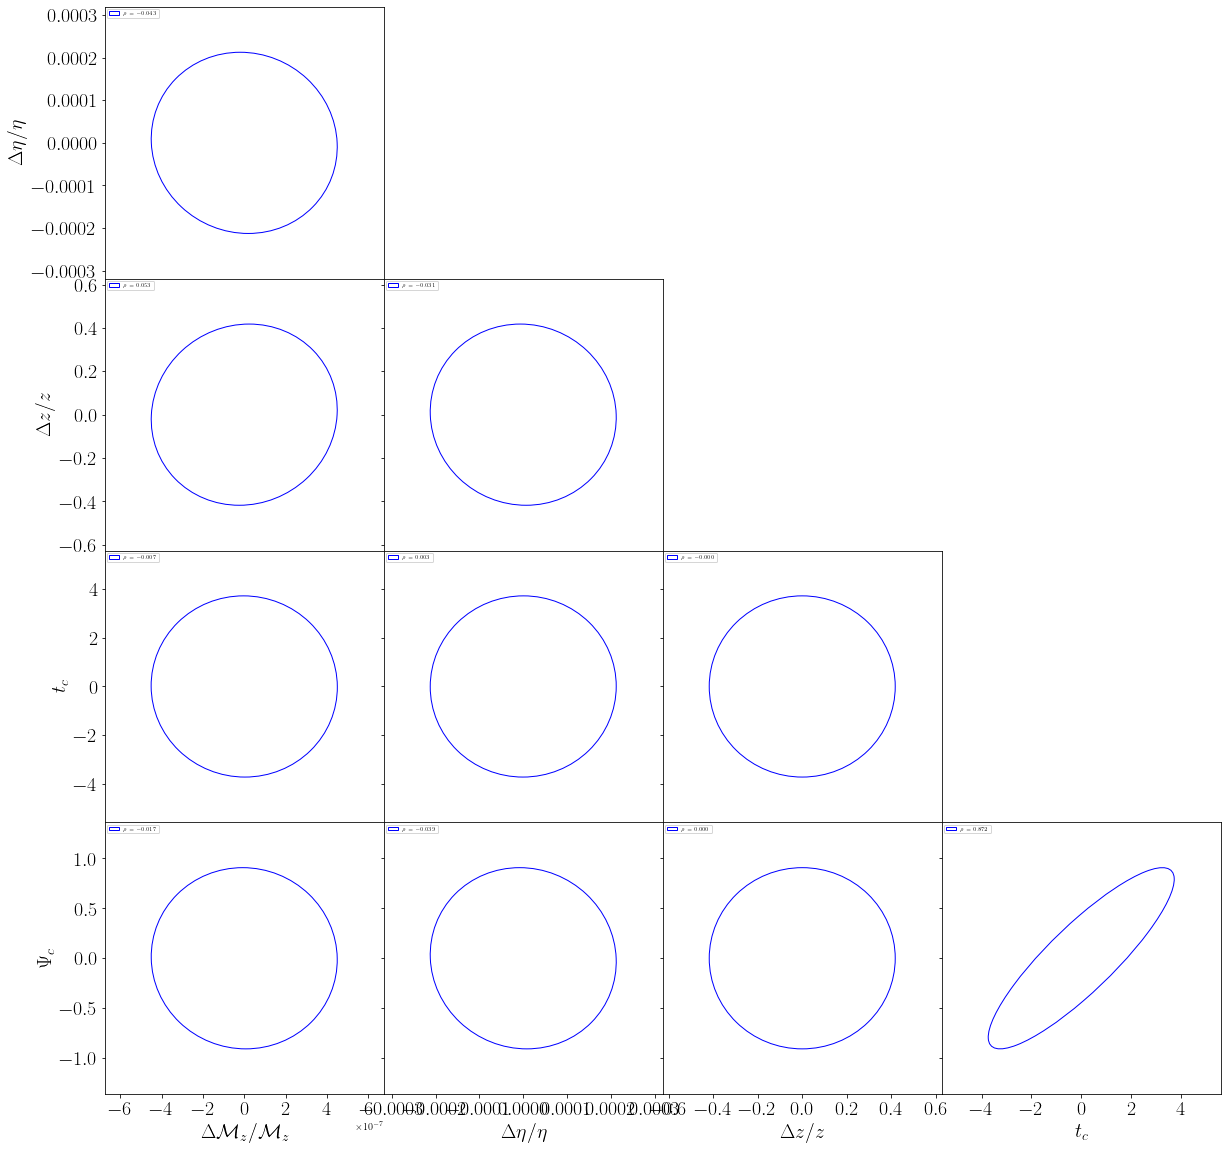

In [19]:
alpha = 1.52            #For 1 sigma

val = [0,0,0,0,0]
nparams = len(val)

label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(nparams-1, nparams-1, hspace=0, wspace=0)

temp=nparams-1

for i in range(0,nparams-1):
    for j in range(1+i,nparams):

        ax = plt.subplot(gs[i+temp*(j-1)])
        
        axis_swap = False       # Default is false.

        # Fisher forecast
        a,b, theta_deg = utilities.ellipse_para(cov_matrix_lisa[i,i], cov_matrix_lisa[j,j], cov_matrix_lisa[i,j]) 
        a1sig, b1sig = alpha*a, alpha*b
        
        if (cov_matrix_lisa[j,j]>cov_matrix_lisa[i,i]):
            theta_deg +=90
            axis_swap = True
           
        rho = cov_matrix_lisa[i,j] / np.sqrt(cov_matrix_lisa[i,i]* cov_matrix_lisa[j,j])

        contour = Ellipse((val[i],val[j]), 2.*a1sig, 2.*b1sig, theta_deg, fill=False, color='b', label=r'$\rho=%.3f$'%rho)

        ax.add_patch(contour)

        if j==temp:
            ax.set_xlabel(label[i], fontsize=20)
            plt.xticks(fontsize=20)
        else:
            ax.set_xticklabels([], fontsize=20)

        if i==0:    
            ax.set_ylabel(label[j], fontsize=20)
            plt.yticks(fontsize=20)
        else:
            ax.set_yticklabels([], fontsize=20)
        
        space_fac = 1.5    #just to pad some white space around the ellipses

        ax.set_xlim(val[i]-space_fac*alpha*np.sqrt(cov_matrix_lisa[i,i]), val[i]+space_fac*alpha*np.sqrt(cov_matrix_lisa[i,i]))
        ax.set_ylim(val[j]-space_fac*alpha*np.sqrt(cov_matrix_lisa[j,j]), val[j]+space_fac*alpha*np.sqrt(cov_matrix_lisa[j,j]))
        
        ax.legend(fontsize=5, loc=2)

# Step function

In [20]:
def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)

    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n

    result *= x ** (N + 1)

    return result

In [21]:
def cT_step(farr, fstar, c0, width):

    logf = np.log10(farr)

    step = smoothstep(x=logf, x_min=np.log10(fstar)-width, x_max=np.log10(fstar)+width, N=5)

    cT_val = (1-c0)*step+c0

    return cT_val

In [22]:
fstar = 0.8
c0 = 0.3
w1 = 0.5


In [23]:
cT_step_fo_w1 = cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

Text(0, 0.5, '$\\Delta$')

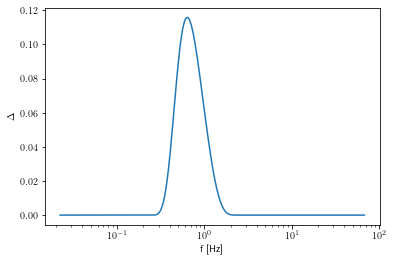

In [24]:
plt.semilogx(farr, Delta_step_w1)
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Delta$')

In [28]:
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

h_Delta_step_w1 = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step_GR, cosmo_params)

TypeError: 'int' object is not subscriptable

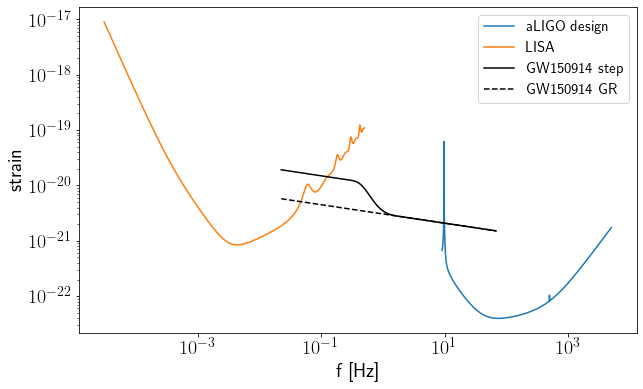

In [25]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_w1), color='k', label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('../plots/amp_psd_step.pdf')

In [26]:
mask_ligo = (farr>ligo_asd[0,0]) & (farr<=ligo_asd[-1,0])
mask_lisa = (farr>LISA_strain[0,0]) & (farr<=LISA_strain[-1,0])

ligo_psd = ligo_interp(farr[mask_ligo])**2
lisa_psd = lisa_interp(farr[mask_lisa])

In [27]:
SNR_ligo_sq = utilities.scalar_product(h_Delta_step_w1[mask_ligo], h_Delta_step_w1[mask_ligo], ligo_psd, farr[mask_ligo])
SNR_ligo_step = np.sqrt(SNR_ligo_sq)

SNR_lisa_sq = utilities.scalar_product(h_Delta_step_w1[mask_lisa], h_Delta_step_w1[mask_lisa], lisa_psd, farr[mask_lisa])
SNR_lisa_step = np.sqrt(SNR_lisa_sq)

print('designed LIGO SNR')
print(SNR_ligo_step)
print('LISA SNR')
print(SNR_lisa_step)

designed LIGO SNR
65.53013936673959
LISA SNR
11.441574186202779


In [56]:
pconstraints_MG_lisa_step, cov_matrix_MG_lisa_step = Fisher_det(farr[mask_lisa], pars_step_GR, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1)
print('LISA')
print('step function')
print(pconstraints_MG_lisa_step)
print('GR')
pconstraints_GR_lisa, cov_matrix_GR_LISA= Fisher_det(farr[mask_lisa], pars_GR, lisa_psd, cosmo_params)
print(pconstraints_GR_lisa)

7.431507201589686e+17
LISA
step function
[2.93568914e-07 1.42226082e-04 2.80378087e-01 9.28662792e+01
 2.32873075e+02 3.65621947e-02]
GR
74596558428305.19
[2.93568592e-07 1.42225760e-04 2.78256099e-01 2.45635133e+00
 5.98804675e-01]


In [57]:
Fisher_matrix_MG_lisa_step = np.linalg.inv(cov_matrix_MG_lisa_step)
Fisher_matrix_MG_lisa_step_fixtc = copy(Fisher_matrix_MG_lisa_step)
Fisher_matrix_MG_lisa_step_fixtc[3,3] = 1.e6
cov_matrix_MG_lisa_step_fixtc = np.linalg.inv(Fisher_matrix_MG_lisa_step_fixtc)

NameError: name 'copy' is not defined

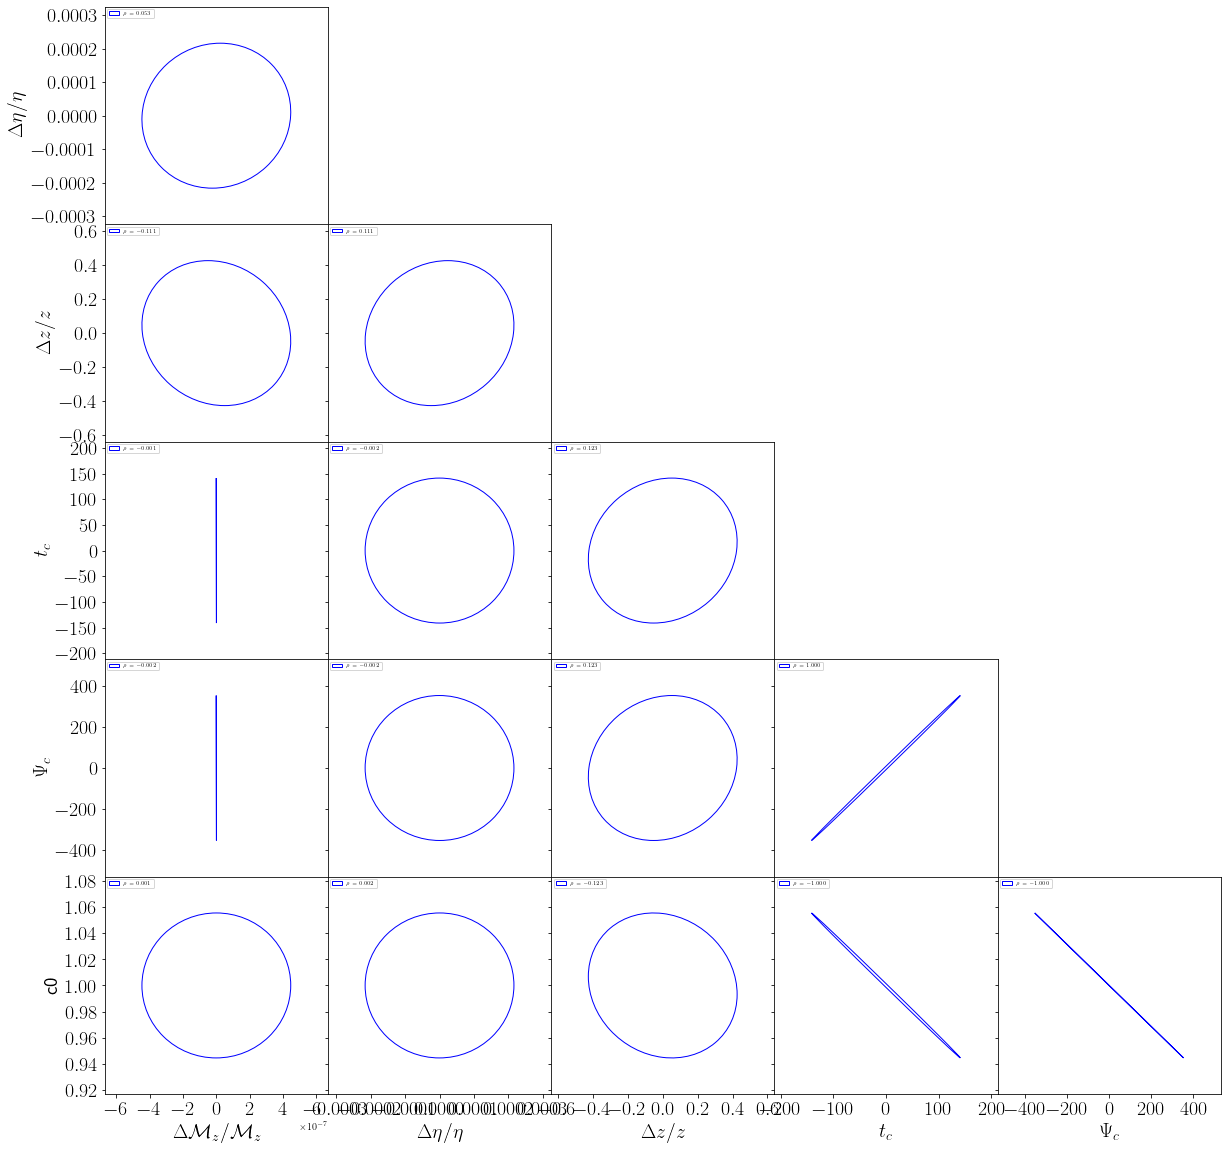

In [38]:
alpha = 1.52            #For 1 sigma

val = [0,0,0,0,0,1]
nparams = len(val)
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(nparams-1, nparams-1, hspace=0, wspace=0)

temp=nparams-1

for i in range(0,nparams-1):
    for j in range(1+i,nparams):

        ax = plt.subplot(gs[i+temp*(j-1)])
        
        axis_swap = False       # Default is false.

        # Fisher forecast
        a,b, theta_deg = utilities.ellipse_para(cov_matrix_MG_lisa_step[i,i], cov_matrix_MG_lisa_step[j,j], cov_matrix_MG_lisa_step[i,j]) 
        a1sig, b1sig = alpha*a, alpha*b
        
        if (cov_matrix_MG_lisa_step[j,j]>cov_matrix_MG_lisa_step[i,i]):
            theta_deg +=90
            axis_swap = True
           
        rho = cov_matrix_MG_lisa_step[i,j] / np.sqrt(cov_matrix_MG_lisa_step[i,i]* cov_matrix_MG_lisa_step[j,j])

        contour = Ellipse((val[i],val[j]), 2.*a1sig, 2.*b1sig, theta_deg, fill=False, color='b', label=r'$\rho=%.3f$'%rho)

        ax.add_patch(contour)

        if j==temp:
            ax.set_xlabel(label[i], fontsize=20)
            plt.xticks(fontsize=20)
        else:
            ax.set_xticklabels([], fontsize=20)

        if i==0:    
            ax.set_ylabel(label[j], fontsize=20)
            plt.yticks(fontsize=20)
        else:
            ax.set_yticklabels([], fontsize=20)
        
        space_fac = 1.5    #just to pad some white space around the ellipses

        ax.set_xlim(val[i]-space_fac*alpha*np.sqrt(cov_matrix_MG_lisa_step[i,i]), val[i]+space_fac*alpha*np.sqrt(cov_matrix_MG_lisa_step[i,i]))
        ax.set_ylim(val[j]-space_fac*alpha*np.sqrt(cov_matrix_MG_lisa_step[j,j]), val[j]+space_fac*alpha*np.sqrt(cov_matrix_MG_lisa_step[j,j]))
        
        ax.legend(fontsize=5, loc=2)

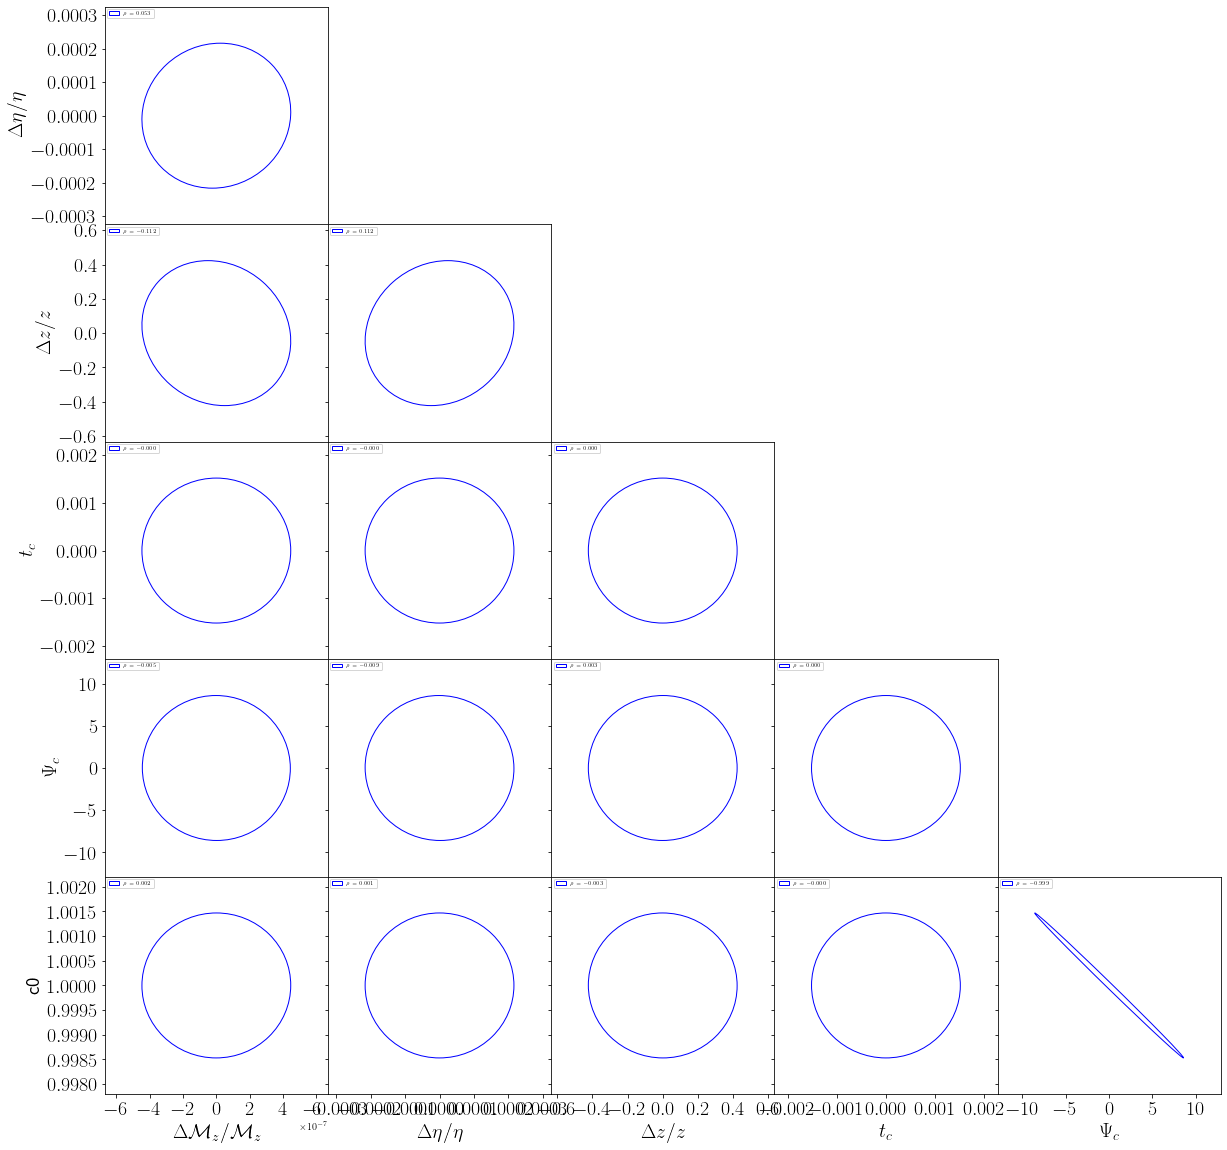

In [39]:
alpha = 1.52            #For 1 sigma

val = [0,0,0,0,0,1]
nparams = len(val)
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(nparams-1, nparams-1, hspace=0, wspace=0)

temp=nparams-1

for i in range(0,nparams-1):
    for j in range(1+i,nparams):

        ax = plt.subplot(gs[i+temp*(j-1)])
        
        axis_swap = False       # Default is false.

        # Fisher forecast
        a,b, theta_deg = utilities.ellipse_para(cov_matrix_MG_lisa_step_fixtc[i,i], cov_matrix_MG_lisa_step_fixtc[j,j], cov_matrix_MG_lisa_step_fixtc[i,j]) 
        a1sig, b1sig = alpha*a, alpha*b
        
        if (cov_matrix_MG_lisa_step_fixtc[j,j]>cov_matrix_MG_lisa_step_fixtc[i,i]):
            theta_deg +=90
            axis_swap = True
           
        rho = cov_matrix_MG_lisa_step_fixtc[i,j] / np.sqrt(cov_matrix_MG_lisa_step_fixtc[i,i]* cov_matrix_MG_lisa_step_fixtc[j,j])

        contour = Ellipse((val[i],val[j]), 2.*a1sig, 2.*b1sig, theta_deg, fill=False, color='b', label=r'$\rho=%.3f$'%rho)

        ax.add_patch(contour)

        if j==temp:
            ax.set_xlabel(label[i], fontsize=20)
            plt.xticks(fontsize=20)
        else:
            ax.set_xticklabels([], fontsize=20)

        if i==0:    
            ax.set_ylabel(label[j], fontsize=20)
            plt.yticks(fontsize=20)
        else:
            ax.set_yticklabels([], fontsize=20)
        
        space_fac = 1.5    #just to pad some white space around the ellipses

        ax.set_xlim(val[i]-space_fac*alpha*np.sqrt(cov_matrix_MG_lisa_step_fixtc[i,i]), val[i]+space_fac*alpha*np.sqrt(cov_matrix_MG_lisa_step_fixtc[i,i]))
        ax.set_ylim(val[j]-space_fac*alpha*np.sqrt(cov_matrix_MG_lisa_step_fixtc[j,j]), val[j]+space_fac*alpha*np.sqrt(cov_matrix_MG_lisa_step_fixtc[j,j]))
        
        ax.legend(fontsize=5, loc=2)

In [53]:
print(Fisher_matrix_MG_lisa_step)

[[ 1.18242624e+13 -1.45332966e+09  1.48872292e+06 -1.09336500e+05
   5.00630603e+05  2.91228254e+09]
 [-1.45332966e+09  5.15565023e+07 -3.08231482e+03 -8.20904922e+02
   3.86135316e+03  2.25061273e+07]
 [ 1.48872292e+06 -3.08231482e+03  1.32687202e+01 -1.05214676e-09
   6.71296415e-09  1.25027339e+01]
 [-1.09336500e+05 -8.20904922e+02 -9.23993178e-13  1.00000000e+06
  -2.49872353e+00 -1.41485643e+04]
 [ 5.00630604e+05  3.86135316e+03  2.30327991e-12 -2.49872353e+00
   1.17821682e+01  6.86986473e+04]
 [ 2.91228255e+09  2.25061273e+07  1.25026938e+01 -1.41485643e+04
   6.86986473e+04  4.01632544e+08]]


In [54]:
print(Fisher_matrix_MG_lisa_step_fixtc)

[[ 1.18242624e+13 -1.45332966e+09  1.48872292e+06 -1.09336500e+05
   5.00630603e+05  2.91228254e+09]
 [-1.45332966e+09  5.15565023e+07 -3.08231482e+03 -8.20904922e+02
   3.86135316e+03  2.25061273e+07]
 [ 1.48872292e+06 -3.08231482e+03  1.32687202e+01 -1.05214676e-09
   6.71296415e-09  1.25027339e+01]
 [-1.09336500e+05 -8.20904922e+02 -9.23993178e-13  1.00000000e+06
  -2.49872353e+00 -1.41485643e+04]
 [ 5.00630604e+05  3.86135316e+03  2.30327991e-12 -2.49872353e+00
   1.17821682e+01  6.86986473e+04]
 [ 2.91228255e+09  2.25061273e+07  1.25026938e+01 -1.41485643e+04
   6.86986473e+04  4.01632544e+08]]
